In [62]:
# prepares the notebook for "inline" graphing, and imports matplotlib library
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import matplotlib.cbook as cbook
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from os import listdir
from os.path import isfile, join

In [63]:
# this is the folder where the NB02 data is stored on your computer
basePath = r'C:\Users\Ted Mburu\Documents\GitHub\Nb02_v2\old\newData'

# these functions are used in determining the type
# of data we are looking at (posthesh, neghold etc)
def isIncreasing(L):
    return L[0] < L[len(L) - 1]
def isDecreasing(L):
    return L[0] > L[len(L) - 1]
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of voltages and currents as arguments
def sortIntoSide(voltage, current):
    if isIncreasing(voltage) and isIncreasing(current):
        return "posThresh"
    elif isDecreasing(voltage) and isDecreasing(current):
        return "posHold"
    elif isDecreasing(voltage) and isIncreasing(current):
        return "negThresh"
    elif isIncreasing(voltage) and isDecreasing(current):
        return "negHold"
    else: 
        print("???")


# this will take a file name and device size and
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, size, fileName):
        self.size = size
        
        if "Sam" in fileName:
            self.version = 2
        else:
            self.version = 1
        
        self.getFileName(fileName) # adds .txt to the file name
        # self.getFileDate() # gets the date the data was taken from filename
        # self.getSampleNumber() # gets the sample number from filename
        # self.getDeviceNumber() # gets the device number from filename
        # self.getDoping() # gets the doping percentage from filename
        
        # self.NbPercentage = (100 - self.doping) / 100
        # self.TiPercentage = self.doping / 100
        # self.NbPercentageString = str(self.NbPercentage)
        # self.TiPercentageString = str(self.TiPercentage)
        
        # # the text displaed on graphs
        # sampleText = '  Sample ' + str(self.sampleNumber)
        # deviceText = '  Device ' + str(self.deviceNumber)
        # nb = 'Nb' if self.NbPercentageString == "1.0" else r'Nb$_{'+ self.NbPercentageString +'}$'
        # ti = '' if self.TiPercentageString == "0.0" else r'Ti$_{'+ self.TiPercentageString +'}$'
        # self.title = nb + ti + r'O$_2$ ' + self.size + ' $\mu$m$^2$,' + sampleText + deviceText
        
        
        self.filePath = self.getFilePath() # combines the filename and base path to get file path
        self.title = self.filePath
        self.getData() # reads the file and stores the current, voltage and time
        self.removeBadData() # removes all data before the device is burned through
        self.findAllIndexes() # gets the indexes that begin and end every run
        self.sortRuns() # sorts runs into their types and stores them
        self.getLargestGradients() # finds the index of the largest second derivative in each run
        self.getLargestGradientVoltage() # stores the voltage at the largest second derivative
        self.getLargestGradientCurrent() # stores the current at the largest second derivative
#         self.printData() # prints all the important data
        self.showFinalGraph() # shows a graph with the important data highlighted

    # adds .txt to the file name
    def getFileName(self, fileName):
        self.fileName = fileName
    
    # combines the filename and base path to get file path
    def getFilePath(self):
        filePath = ''
        # if (self.doping == 5):
        #     filePath = basePath + r'\Doping05\ '.rstrip()
        # elif (self.doping == 10):
        #     filePath = basePath + r'\Doping10\ '.rstrip()
        # else: 
        #     filePath = basePath + r'\Doping0\ '.rstrip() 
        filePath = filePath + self.fileName
        # print(filePath)
        return filePath
    
    # gets the date the data was taken from filename
    def getFileDate(self):
        if self.version == 1:
            dateMeasured = self.fileName.split("-")[1]
            self.dateMeasuredText = dateMeasured[:2] + '/' + dateMeasured[2:4] + "/" + dateMeasured[4:]
        elif self.version == 2:
            dateMeasured = self.fileName.split("Sam")[1].split("_")[1]
            self.dateMeasuredText = dateMeasured[:2] + '/' + dateMeasured[2:4] + "/20" + dateMeasured[4:]
        self.dateMeasured = dateMeasured
        
    # gets the sample number from filename
    def getSampleNumber(self):
        sampleNumber = self.fileName.split("_")[1].split("-")[0]
        self.sampleNumber = sampleNumber
        
    # gets the doping percentage from filename
    def getDoping(self): 
        # the two versions are the filenames with "Sam" in them and the rest
        if self.version == 1: 
            doping = self.fileName.split("IVNb")[1].split("Ti")[0]
            if doping == "1p00":
                doping = 0
            elif doping == "0p100":
                doping = 0
            elif doping == "0p95":
                doping = 5
            elif doping == "0p90":
                doping = 10
            else: 
                print("???")
        elif self.version == 2:
            doping = self.fileName.split("Ti")[1].split("_")[0]
        else:
            print("version?")
        self.doping = int(doping)
        
    # gets the device number from filename
    def getDeviceNumber(self): 
        # files.append(DataFile("2x2",   r'IVs_NbO2_Ti10_Sam24_051722_D1'))
        # files.append(DataFile("4x4",   r'IVs_NbO2_Ti0_Sam2_2nd_060222_04a'))
        # files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam3_071322_1'))
        if self.version == 1:
            deviceNumber = self.fileName[:-4].split(self.dateMeasured)[1].split("-")[1]
            self.deviceNumber = deviceNumber[1:]
        elif self.version == 2:
            deviceNumber = self.fileName[:-4].split(self.dateMeasured)[1].split("_")[1]
            self.deviceNumber = deviceNumber[1:]
        else: 
            print("device?")
        # print("last 4: ", self.fileName[-8:])
    
    # reads the file and stores the current, voltage and time
    def getData(self):
        df5 = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'],sep='\t',skiprows=1)
        data = df5.values
        df5.head()
        self.t = data[:,0]
        self.I = data[:,1]
        self.V = data[:,2]
        self.temps = data[:,3]

        
        
        i = np.abs(np.array(self.I))
        v = np.abs(np.array(self.V))
        r = np.divide(v, i)
        self.R = [x for x in r if np.isnan(x) == False]
        # x for x in mylist if np.isnan(x) == False 
    
    # removes all data before the device is burned through
    def removeBadData(self):
        largestCurrent = np.amax(self.I)
        maxCurrentThreshhold = largestCurrent * 0.80
        indexOfFirstLargeCurrent = np.argmax(self.I > maxCurrentThreshhold)
        
        self.t= self.t[indexOfFirstLargeCurrent:]
        self.I= self.I[indexOfFirstLargeCurrent:]
        self.V= self.V[indexOfFirstLargeCurrent:]
        self.maxCurrentThreshhold = maxCurrentThreshhold
    
    # gets the indexes that begin and end every run
    def findAllIndexes(self):
        allZeroIndexes = []
        zeroIndexes = []
        allMaxIndexes = []
        maxIndexes = []
        newMaxIndexes = []
        allIndexes = []

        # indexes of values that are pretty much 0
        self.zeroThreshhold = 1e-5
        for index, x in enumerate(self.I):
            if x < self.zeroThreshhold:
                allZeroIndexes.append(index)

        # find the zero values that begin or end a run
        zeroIndexes.append(allZeroIndexes[0])
        for x in range(len(allZeroIndexes) - 1):
            if allZeroIndexes[x]+1 != allZeroIndexes[x+1]:
                zeroIndexes.append(allZeroIndexes[x])
                zeroIndexes.append(allZeroIndexes[x+1])
    
        for index, x in enumerate(self.I):
            if x > self.maxCurrentThreshhold:
                allMaxIndexes.append(index)

        # find the max values that start or end a run
        for x in range(len(allMaxIndexes) - 1):
            if allMaxIndexes[x]+1 != allMaxIndexes[x+1]:
                maxIndexes.append(allMaxIndexes[x])
                maxIndexes.append(allMaxIndexes[x+1])
                
        for x in range(len(allMaxIndexes) - 1):
            if allMaxIndexes[x]+1 != allMaxIndexes[x+1]:
                newMaxIndexes.append(allMaxIndexes[x]+1)
                newMaxIndexes.append(allMaxIndexes[x+1]+1)
        
        allIndexes = [*zeroIndexes, *maxIndexes]
        allIndexes = sorted(allIndexes)

        for x in range(3, len(allIndexes) - 1, 4):
            allIndexes[x] = allIndexes[x] + 1

        goodRuns = []
        for x in range(0, len(allIndexes) - 4, 4):
            if monotonic( self.V[allIndexes[x]:allIndexes[x+3]] ):
                goodRuns.append(allIndexes[x])
                goodRuns.append(allIndexes[x+1])
                goodRuns.append(allIndexes[x+2])
                goodRuns.append(allIndexes[x+3])

        allIndexes = np.copy(goodRuns)
        self.allIndexes = allIndexes
        self.zeroIndexes = zeroIndexes
        
    # sorts runs into their types and stores them
    def sortRuns(self):
        posThreshValues = []
        negThreshValues = []
        posHoldValues = []
        negHoldValues = []

        timesToLoop = len(self.zeroIndexes) - 1
        for x in range(0, timesToLoop, 2):
            voltageRun = []
            currentRun = []
            timeRun = []
            secondDerivativeRun = []
            start = self.allIndexes[x]
            stop = self.allIndexes[x+1]
            for y in range(start, stop):
                voltageRun.append(self.V[y])
                currentRun.append(self.I[y])
                timeRun.append(self.t[y])
                secondDerivativeRun.append(self.I[y])
            if len(currentRun) > 4:
                secondDerivativeCurrent = np.gradient(np.gradient(currentRun))
                runType = sortIntoSide(voltageRun, currentRun)
                currentRun = [ abs(x) for x in currentRun]
                runData = [timeRun, voltageRun, currentRun, secondDerivativeCurrent]
                if (runType == "posThresh"):
                    posThreshValues.append(runData)
                elif (runType == "posHold"):
                    posHoldValues.append(runData)
                elif (runType == "negThresh"):
                    negThreshValues.append(runData)
                elif (runType == "negHold"):
                    negHoldValues.append(runData)
        self.posThreshValues = posThreshValues
        self.negThreshValues = negThreshValues
        self.posHoldValues = posHoldValues
        self.negHoldValues = negHoldValues
    
    # finds the index of the largest second derivative in each run
    def getLargestGradients(self):
        # take second derivative of each current array
        posThreshValuesGradients = []
        negThreshValuesGradients = []
        posHoldValuesGradients = []
        negHoldValuesGradients = []

        for x in self.posThreshValues:
            posThreshValuesGradients.append(x[3])
        for x in self.negThreshValues:
            negThreshValuesGradients.append(x[3])
        for x in self.posHoldValues:
            posHoldValuesGradients.append(x[3])
        for x in self.negHoldValues:
            negHoldValuesGradients.append(x[3])
            
        self.posThreshValuesGradients = posThreshValuesGradients
        self.negThreshValuesGradients = negThreshValuesGradients
        self.posHoldValuesGradients = posHoldValuesGradients
        self.negHoldValuesGradients = negHoldValuesGradients

        # find the index of the largest value in the 2nd derivative
        posThreshValuesLargestGradient = []
        negThreshValuesLargestGradient = []
        posHoldValuesLargestGradient = []
        negHoldValuesLargestGradient = []

        for x in posThreshValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            posThreshValuesLargestGradient.append(largestValue)
        for x in negThreshValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            negThreshValuesLargestGradient.append(largestValue)
        for x in posHoldValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            posHoldValuesLargestGradient.append(largestValue)
        for x in negHoldValuesGradients:
            largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
            negHoldValuesLargestGradient.append(largestValue)
            
        self.posThreshValuesLargestGradient = posThreshValuesLargestGradient
        self.negThreshValuesLargestGradient = negThreshValuesLargestGradient
        self.posHoldValuesLargestGradient = posHoldValuesLargestGradient
        self.negHoldValuesLargestGradient = negHoldValuesLargestGradient
    
    # stores the voltage at the largest second derivative
    def getLargestGradientVoltage(self):
        posThreshValuesVoltage = []
        negThreshValuesVoltage = []
        posHoldValuesVoltage = []
        negHoldValuesVoltage = []

        for x in range(len(self.posThreshValuesGradients)):
            voltage = self.posThreshValues[x][1][self.posThreshValuesLargestGradient[x]]
            posThreshValuesVoltage.append(voltage)
        for x in range(len(self.negThreshValuesGradients)):
            voltage = self.negThreshValues[x][1][self.negThreshValuesLargestGradient[x]]
            negThreshValuesVoltage.append(voltage)
        for x in range(len(self.posHoldValuesGradients)):
            voltage = self.posHoldValues[x][1][self.posHoldValuesLargestGradient[x]]
            posHoldValuesVoltage.append(voltage)
        for x in range(len(self.negHoldValuesGradients)):
            voltage = self.negHoldValues[x][1][self.negHoldValuesLargestGradient[x]]
            negHoldValuesVoltage.append(voltage)
        
        self.posThreshValuesVoltage = posThreshValuesVoltage
        self.negThreshValuesVoltage = negThreshValuesVoltage
        self.posHoldValuesVoltage = posHoldValuesVoltage
        self.negHoldValuesVoltage = negHoldValuesVoltage
        
    # stores the current at the largest second derivative
    def getLargestGradientCurrent(self):
        posThreshValuesCurrent = []
        negThreshValuesCurrent = []
        posHoldValuesCurrent = []
        negHoldValuesCurrent = []

        for x in range(len(self.posThreshValuesGradients)):
            current = self.posThreshValues[x][2][self.posThreshValuesLargestGradient[x]]
            posThreshValuesCurrent.append(current)
        for x in range(len(self.negThreshValuesGradients)):
            current = self.negThreshValues[x][2][self.negThreshValuesLargestGradient[x]]
            negThreshValuesCurrent.append(current)
        for x in range(len(self.posHoldValuesGradients)):
            current = self.posHoldValues[x][2][self.posHoldValuesLargestGradient[x]]
            posHoldValuesCurrent.append(current)
        for x in range(len(self.negHoldValuesGradients)):
            current = self.negHoldValues[x][2][self.negHoldValuesLargestGradient[x]]
            negHoldValuesCurrent.append(current)
        
        self.posThreshValuesCurrent = posThreshValuesCurrent
        self.negThreshValuesCurrent = negThreshValuesCurrent
        self.posHoldValuesCurrent = posHoldValuesCurrent
        self.negHoldValuesCurrent = negHoldValuesCurrent
    
    # prints all the important data
    def printData(self):
        averages = []
        averages[0] = average(self.posThreshValuesVoltage)
        averages[1] = average(self.negThreshValuesVoltage)
        averages[2] = average(self.posHoldValuesVoltage)
        averages[3] = average(self.negHoldValuesVoltage)
        
        standardDeviations = []
        standardDeviations[0] = np.std(self.posThreshValuesVoltage)
        standardDeviations[1] = np.std(self.negThreshValuesVoltage)
        standardDeviations[2] = np.std(self.posHoldValuesVoltage)
        standardDeviations[3] = np.std(self.negHoldValuesVoltage)
        
        print("Positive Threshold Voltage: ", averages[0] , "Standard Deviation: ", standardDeviations[0])
        print("Negative Threshold Voltage: ", averages[1], "Standard Deviation: ", standardDeviations[1])
        print("Positive Hold Voltage: ", averages[2], "Standard Deviation: ", standardDeviations[2])
        print("Negative Hold Voltage: ", averages[3], "Standard Deviation: ", standardDeviations[3])
        print()
        
    # shows a graph with the important data highlighted
    def showFinalGraph(self):
        # plt.rcParams['figure.figsize'] = (6,5)
        fig, ax = plt.subplots(figsize =(6, 5))
        plt.figure(len(files))
        plt.grid()
        plt.semilogy(self.V, self.I)
        plt.xlabel('Voltage (V)', fontsize=16);
        plt.ylabel('Current (A)', fontsize=16);
        # ax.set_ylim([1e-9, 3e-3])
        # ax.set_xlim([-1, 1])

        # plt.axhline(y=self.maxCurrentThreshhold, color='r', linestyle='-')
        # plt.axhline(y=self.zeroThreshhold, color='r', linestyle='-')

        # if len(self.posThreshValuesVoltage) > 1:
        #     voltage = average(self.posThreshValuesVoltage)
        #     current = average(self.posThreshValuesCurrent)
        #     plt.errorbar(voltage, current, xerr=np.std(self.posThreshValuesVoltage), fmt="ro")

        # if len(self.negThreshValuesVoltage) > 1:
        #     voltage = average(self.negThreshValuesVoltage)
        #     current = average(self.negThreshValuesCurrent)
        #     plt.errorbar(voltage, current, xerr=np.std(self.negThreshValuesVoltage), fmt="bo")

        # if len(self.posHoldValuesVoltage) > 1:
        #     voltage = average(self.posHoldValuesVoltage)
        #     current = average(self.posHoldValuesCurrent)
        #     plt.errorbar(voltage, current, xerr=np.std(self.posHoldValuesVoltage), fmt="go")

        # if len(self.negHoldValuesVoltage) > 1:
        #     voltage = average(self.negHoldValuesVoltage)
        #     current = average(self.negHoldValuesCurrent)
        #     plt.errorbar(voltage, current, xerr=np.std(self.negHoldValuesVoltage), fmt="yo")

        plt.title(self.title);
        # plt.show()

C:\Users\Ted Mburu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ted Mburu\AppData\Local\Temp\ipykernel_13628\154867275.py:167: RuntimeWarning: invalid value encountered in greater
  indexOfFirstLargeCurrent = np.argmax(self.I > maxCurrentThreshhold)


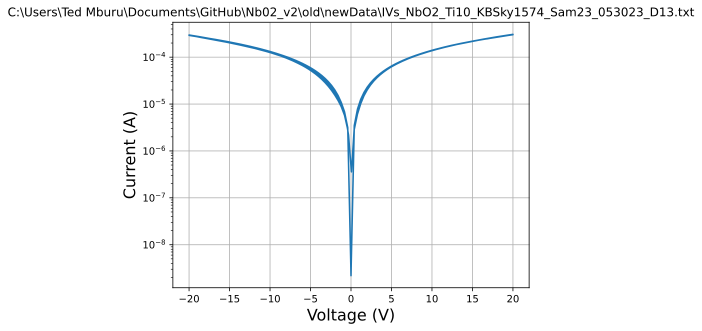

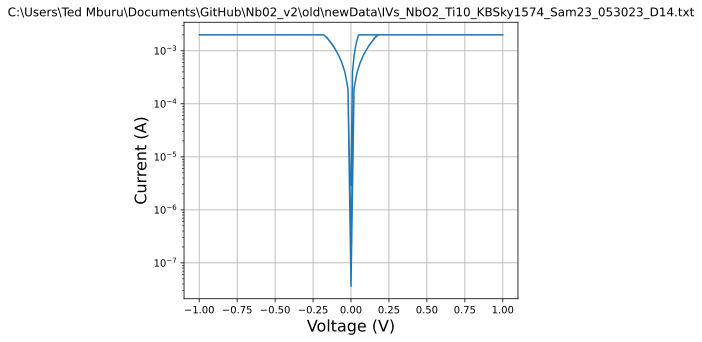

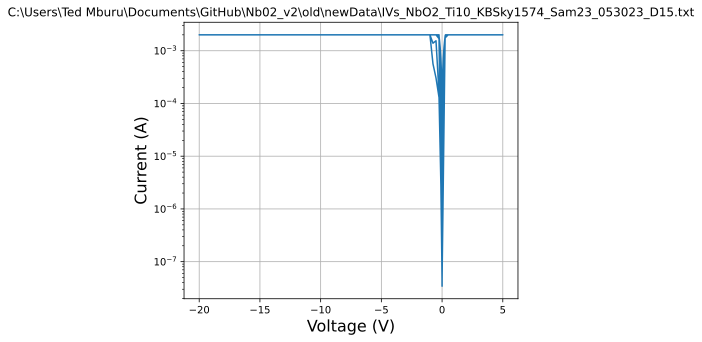

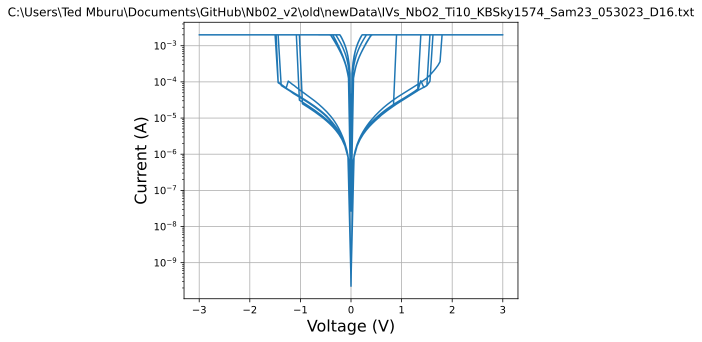

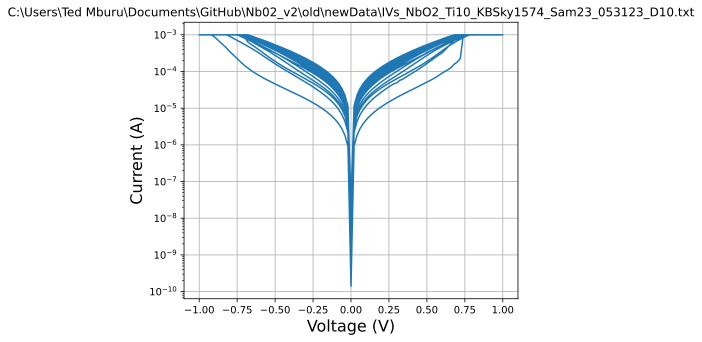

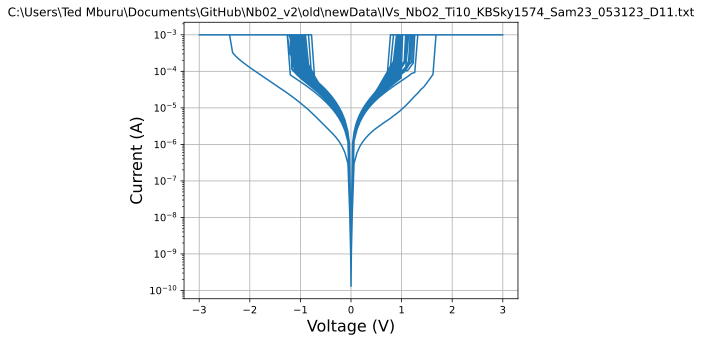

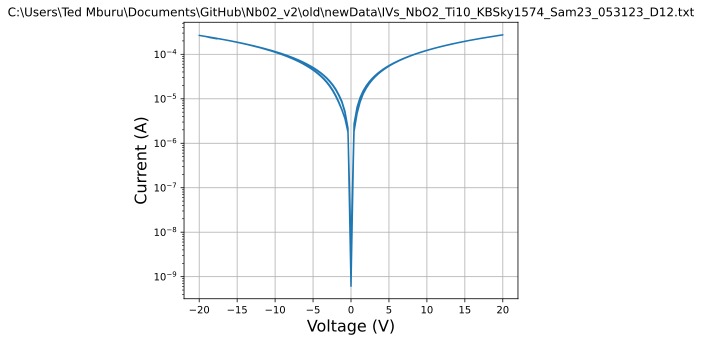

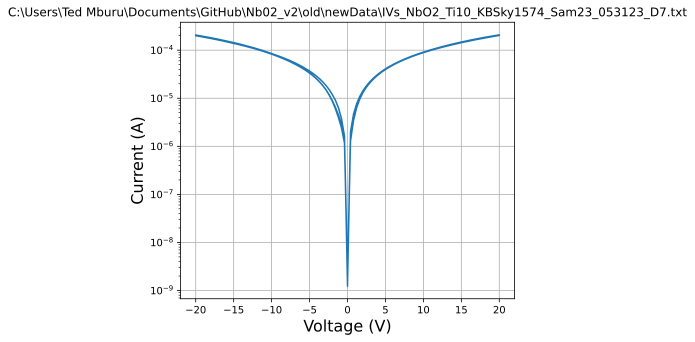

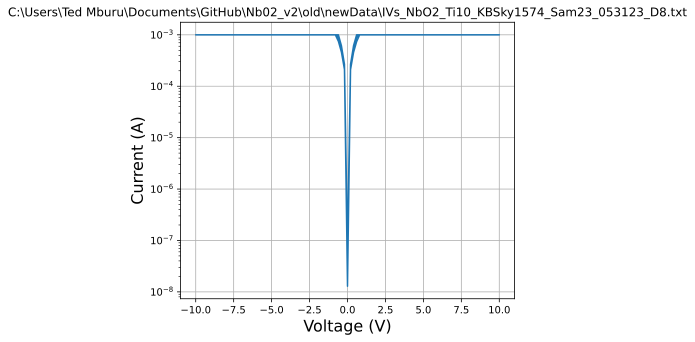

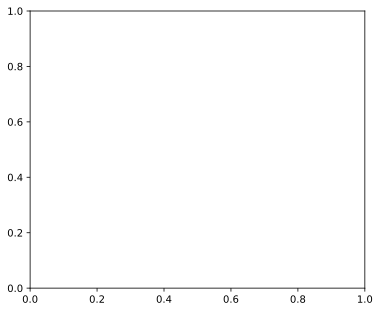

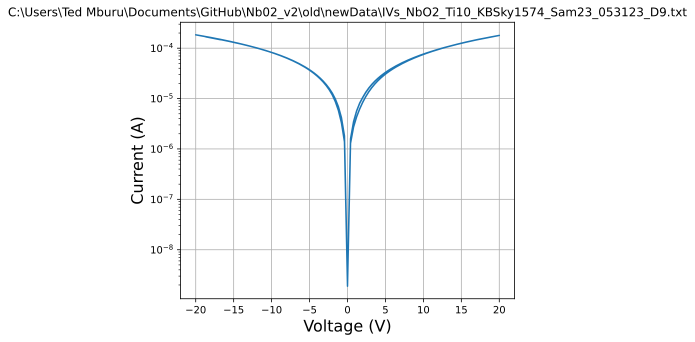

In [64]:
# files = [] # stores all the files data as DataFile objects

# files.append(DataFile("2x2", r'IVs_NbO2_Ti10_Sam24_051722_D1'))
# files.append(DataFile("4x4", r'IVs_NbO2_Ti0_Sam2_2nd_060222_04a'))
# files.append(DataFile("15x15", r'IVs_NbO2_Ti0_Sam3_071322_1'))

files = []
for fileName in listdir(basePath):
    fullPath = join(basePath, fileName)
    # print(fileName)
    # print(fullPath)
    if isfile(fullPath):
        files.append(DataFile("2x2", fullPath))

# files.append(DataFile("15x15", r'IVNb1p00Ti0p00O2_13-03222022-08a'))

# IVNb1p00Ti0p00O2_13-03222022-08a

#  largest - (f)
#  smallest - (e)